<a href="https://colab.research.google.com/github/phuongnguyen99/Pytorch_projects/blob/main/Neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Library
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [13]:
# Setting model as Vgg19
model = models.vgg19(pretrained = True).features
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
# Define VGG model
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    # Choose intermediate layers from our model
    self.chosen_features = ["0", "5", "10", "19", "28"]
    self.model = models.vgg19(pretrained = True).features[:29]

  def forward(self,x):
    # store relevant feature
    features = []
    # go through all of features in the model, only select features which are in chosen_features 
    # we return all activations for specific layers in chosen features
    for layer_num, layer in enumerate(self.model):
      x = layer(x)
      if str(layer_num) in self.chosen_features:
        features.append(x)
    return features

In [4]:
# Load image function
def load_image(img):
  image = Image.open(img)
  image = loader(image).unsqueeze(0)
  return image.to(device)

In [14]:
# Set up device to run the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

In [6]:
from torchvision.transforms.transforms import ToTensor
loader = transforms.Compose(
    [transforms.Resize((imsize, imsize)),
    transforms.ToTensor(),])

In [7]:
# Content and style image
style = load_image('sample_data/style.jpeg')
original = load_image('sample_data/dog.jpg')

In [8]:
generated = original.clone().requires_grad_(True)
model = VGG().to(device).eval()

In [10]:
# hyper parameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
# optimizer 
optimizer = optim.Adam([generated], lr = learning_rate)

In [11]:
for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original)
    style_features = model(style)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        # content loss: eucledian distance betwen generated image and input image
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        # style loss: eucledian distance between generated image and style image
        style_loss += torch.mean((G - A) ** 2)
  
    # Total loss is the sum of alpha times content loss and beta times style loss
    total_loss = alpha * original_loss + beta * style_loss
    # optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")

tensor(1466230.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(62081.0312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32349.8906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20167.1484, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13246.9170, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9151.3828, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6774.0464, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5402.0410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4589.9658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4071.9028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3709.1982, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3434.9229, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3213.4404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3025.8230, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2861.8938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2716.9883, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2588.0820, device='cuda:0', grad_fn=<AddBa

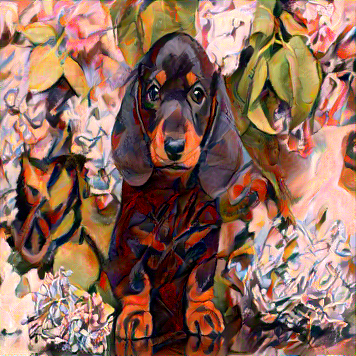

In [12]:
display(Image.open("generated.png"))